In [0]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
trxn_MSM = spark.read.format("com.crealytics.spark.excel").option("dataAddress", "transactions!").option('treatEmptyValuesAsNulls', 'false').option("header", 'true').option("inferSchema", 'true').load("dbfs:/FileStore/tables/ACSE___Mahou_San_Miguel_data.xlsx").toPandas()
prod_MSM = spark.read.format("com.crealytics.spark.excel").option("dataAddress", "products!").option('treatEmptyValuesAsNulls', 'false').option("header", 'true').option("inferSchema", 'true').load("dbfs:/FileStore/tables/ACSE___Mahou_San_Miguel_data.xlsx").toPandas()
season_MSM = spark.read.format("com.crealytics.spark.excel").option("dataAddress", "seasonality!").option('treatEmptyValuesAsNulls', 'false').option("header", 'true').option("inferSchema", 'true').load("dbfs:/FileStore/tables/ACSE___Mahou_San_Miguel_data.xlsx").toPandas()
promo_MSM = spark.read.format("com.crealytics.spark.excel").option("dataAddress", "promo_ad!").option('treatEmptyValuesAsNulls', 'false').option("header", 'true').option("inferSchema", 'true').load("dbfs:/FileStore/tables/ACSE___Mahou_San_Miguel_data.xlsx").toPandas()
holiday_MSM = spark.read.format("com.crealytics.spark.excel").option("dataAddress", "event_holiday!").option('treatEmptyValuesAsNulls', 'false').option("header", 'true').option("inferSchema", 'true').load("dbfs:/FileStore/tables/ACSE___Mahou_San_Miguel_data.xlsx").toPandas()

Define Functions

In [0]:
import math
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def grp_adstock(grp, h):
    r = 1 - 0.5**(1/h)
    adstock = np.zeros(len(grp))
    adstock[0] = grp[0]
    for i in range(1,len(grp)):
        adstock[i] = r*grp[i] + (1-r)*adstock[i-1]
    return adstock

def ads_reach(ads, a, b):
    reach = a*(1-np.exp(-b*ads))
    return reach

def pivot_promo(prod):
    promo = promo_MSM[(promo_MSM[prod]==1)&(promo_MSM.unit!='GRP')][['year','week','vehicle','amount','unit']]
    promo = pd.pivot_table(promo, values='amount', index=['year', 'week'], columns=['vehicle'], aggfunc=sum).reset_index()
    promo = pd.merge(year_week,promo,on=['week','year'],how='left')
    scaler_FB = promo['Facebook Banner'].mean()
    scaler_G = promo['Google Paid Search'].mean()
    promo['Facebook Banner Scaled_Imp'] = promo['Facebook Banner']/scaler_FB
    promo['Google Paid Search Scaled_Imp'] = promo['Google Paid Search']/scaler_G
    promo = promo.fillna(0)
    promo = promo[['year','week','Display','Flyer','Facebook Banner Scaled_Imp','Google Paid Search Scaled_Imp']] #  Scaled_Imp
    return promo

def mean_center(df, cols):
    for col in cols:
        df['Scaled_'+col] = df[col]/df[col].mean()
    return df

def log_trans(df, cols):
    for col in cols:
        df['Log_'+col] = np.log(df[col])
    return df

def data_split(df, features, target):
    X = df[features]
    y = df[target]
    # split by time
    X_train = X.iloc[:72,:]
    X_test = X.iloc[72:,:]
    y_train = y[:72]
    y_test = y[72:]
    return X, y, X_train, y_train, X_test, y_test

def accuracy_evaluate(y, y_pred, y_train, y_pred_train, y_test, y_pred_test):
    # Calculate MAPE and RMSE
    mape = mean_absolute_percentage_error(y, y_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    # Print the results
    print('MAPE:', mape)
    print('MAPE Train:', mape_train)
    print('MAPE Test:', mape_test)
    print('RMSE:', rmse)
    print('RMSE Train:', rmse_train)
    print('RMSE Test:', rmse_test)

Data Processing

In [0]:
trxn_MSM['year'] = (trxn_MSM.trans_dt - pd.Timedelta(days=6)).dt.isocalendar().iloc[:,0]
trxn_MSM['week'] = (trxn_MSM.trans_dt - pd.Timedelta(days=6)).dt.isocalendar().iloc[:,1]
trxn_MSM['price']=trxn_MSM['sales_amt']/trxn_MSM['sales_qty']
week_sales_MSM = trxn_MSM.groupby(['week','year','prod_id'], as_index=False).agg(qty_week=('sales_qty','sum'), amt_week=('sales_amt','sum'),uni_cust = ('cust_id',pd.Series.nunique), price=('price','mean')).sort_values(['year','week'])
org_price_2 = trxn_MSM[(trxn_MSM.prod_id==23141592)].price.value_counts().index[0]
org_price_3 = trxn_MSM[(trxn_MSM.prod_id==23141593)].price.value_counts().index[0]
week_sales_MSM['discount'] = np.where(week_sales_MSM.prod_id==23141592, week_sales_MSM['price']/org_price_2, week_sales_MSM['price']/org_price_3)

,week,year,prod_id,qty_week,amt_week,uni_cust,price,discount
6,4,2019,23141592.0,1886.0,7525.14,1234,3.99,0.799599
7,4,2019,23141593.0,2465.0,24625.35,2216,9.99,0.714081
10,5,2019,23141592.0,777.0,3877.23,512,4.99,1.000000
11,5,2019,23141593.0,655.0,9163.45,641,13.99,1.000000
14,6,2019,23141592.0,576.0,2874.24,382,4.99,1.000000
...,...,...,...,...,...,...,...,...
189,49,2020,23141593.0,102.0,1426.98,102,13.99,1.000000
192,50,2020,23141592.0,630.0,3143.70,404,4.99,1.000000
193,50,2020,23141593.0,145.0,2028.55,142,13.99,1.000000
196,51,2020,23141592.0,887.0,4071.33,553,4.59,0.919840


In [0]:
season_MSM = pd.merge(season_MSM, holiday_MSM, on='week',how='left')
season_MSM = season_MSM.rename(columns = {'week':'week_date'})
season_MSM['year'] = (season_MSM.week_date - pd.Timedelta(days=6)).dt.isocalendar().iloc[:,0]
season_MSM['week'] = (season_MSM.week_date - pd.Timedelta(days=6)).dt.isocalendar().iloc[:,1]
season_MSM_1920 = season_MSM[season_MSM.year>=2019].sort_values(['year','week'])
holiday_dummy = pd.get_dummies(season_MSM_1920['event_holiday'])
season_MSM_1920 = pd.concat([season_MSM_1920,holiday_dummy], axis=1)
week_sales_MSM = pd.merge(week_sales_MSM,season_MSM_1920[season_MSM_1920.columns[[1,*range(3,15)]]],on=['week','year'],how='left')
week_sales_MSM_2 = week_sales_MSM[week_sales_MSM.prod_id==23141592]
week_sales_MSM_3 = week_sales_MSM[week_sales_MSM.prod_id==23141593]
week_sales_MSM

,week,year,prod_id,qty_week,amt_week,uni_cust,price,discount,seas_index,Christmas,Easter,Halloween,Labor Day,Memorial Day,National Day,New Year,Pre Easter,Pre Super Bowl,Super Bowl
0,4,2019,23141592.0,1886.0,7525.14,1234,3.99,0.799599,0.870610,0,0,0,0,0,0,0,0,1,0
1,4,2019,23141593.0,2465.0,24625.35,2216,9.99,0.714081,0.870610,0,0,0,0,0,0,0,0,1,0
2,5,2019,23141592.0,777.0,3877.23,512,4.99,1.000000,0.927523,0,0,0,0,0,0,0,0,0,1
3,5,2019,23141593.0,655.0,9163.45,641,13.99,1.000000,0.927523,0,0,0,0,0,0,0,0,0,1
4,6,2019,23141592.0,576.0,2874.24,382,4.99,1.000000,0.883042,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,49,2020,23141593.0,102.0,1426.98,102,13.99,1.000000,0.715360,0,0,0,0,0,0,0,0,0,0
196,50,2020,23141592.0,630.0,3143.70,404,4.99,1.000000,1.057361,0,0,0,0,0,0,0,0,0,0
197,50,2020,23141593.0,145.0,2028.55,142,13.99,1.000000,1.057361,0,0,0,0,0,0,0,0,0,0
198,51,2020,23141592.0,887.0,4071.33,553,4.59,0.919840,1.157014,1,0,0,0,0,0,0,0,0,0


In [0]:
promo_MSM = promo_MSM.rename(columns = {'week':'week_date'})
promo_MSM['year'] = (promo_MSM.week_date - pd.Timedelta(days=6)).dt.isocalendar().iloc[:,0]
promo_MSM['week'] = (promo_MSM.week_date - pd.Timedelta(days=6)).dt.isocalendar().iloc[:,1]
promo_MSM['23141592'] = np.where((promo_MSM.prod_id=='23141592')|(promo_MSM.prod_id=='ALL'), 1, 0)
promo_MSM['23141593'] = np.where((promo_MSM.prod_id=='23141593')|(promo_MSM.prod_id=='ALL'), 1, 0)

In [0]:
# GRP
years = [2019, 2020]
weeks = range(0, 53)
year_week = pd.DataFrame([(year, week) for year in years for week in weeks], columns=['year', 'week'])
Radio_GRP = promo_MSM[(promo_MSM.unit=='GRP')&(promo_MSM.vehicle=='Radio')][['year','week','amount']].sort_values(['year','week'])
TV_GRP = promo_MSM[(promo_MSM.unit=='GRP')&(promo_MSM.vehicle=='TV')][['year','week','amount']].sort_values(['year','week'])
Radio_GRP = pd.merge(year_week,Radio_GRP,on=['week','year'],how='left')
TV_GRP = pd.merge(year_week,TV_GRP,on=['week','year'],how='left')
Radio_GRP['amount'] = Radio_GRP['amount'].fillna(0)
TV_GRP['amount'] = TV_GRP['amount'].fillna(0)
h_R = 3
h_TV = 6
ads_R = grp_adstock(Radio_GRP.amount, h_R)
ads_TV = grp_adstock(TV_GRP.amount, h_TV)
Radio_GRP['adstock'] = ads_R
TV_GRP['adstock'] = ads_TV
reach_R = ads_reach(Radio_GRP.adstock, 0.9, 0.5)
reach_TV = ads_reach(TV_GRP.adstock, 0.95, 0.4)
Radio_GRP['reach'] = reach_R
TV_GRP['reach'] = reach_TV
# rename the 'old_name' column to 'new_name'
Radio_GRP = Radio_GRP.rename(columns={'reach': 'Radio_reach'})
TV_GRP = TV_GRP.rename(columns={'reach': 'TV_reach'})
reach = pd.merge(Radio_GRP[['year','week','Radio_reach']], TV_GRP[['year','week','TV_reach']], on=['week','year'])
reach

In [0]:
promo_2 = pivot_promo('23141592')
promo_3 = pivot_promo('23141593')
week_sales_MSM_2 = pd.merge(week_sales_MSM_2,promo_2,on=['week','year'],how='inner')
week_sales_MSM_3 = pd.merge(week_sales_MSM_3,promo_3,on=['week','year'],how='inner')
week_sales_MSM_2 = pd.merge(week_sales_MSM_2, reach,on=['week','year'],how='inner')
week_sales_MSM_3 = pd.merge(week_sales_MSM_3, reach,on=['week','year'],how='inner')
week_sales_MSM_3

,week,year,prod_id,qty_week,amt_week,uni_cust,price,discount,seas_index,Christmas,Easter,Halloween,Labor Day,Memorial Day,National Day,New Year,Pre Easter,Pre Super Bowl,Super Bowl,Display,Flyer,Facebook Banner Scaled_Imp,Google Paid Search Scaled_Imp,Radio_reach,TV_reach
0,4,2019,23141593.0,2465.0,24625.35,2216,9.99,0.714081,0.870610,0,0,0,0,0,0,0,0,1,0,1.0,1.0,1.822131,1.341003,0.806042,0.825045
1,5,2019,23141593.0,655.0,9163.45,641,13.99,1.000000,0.927523,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.574221,1.284005,0.810589,0.794092
2,6,2019,23141593.0,241.0,3371.59,240,13.99,1.000000,0.883042,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.594170,1.128430,0.756028,0.760112
3,7,2019,23141593.0,174.0,2434.26,172,13.99,1.000000,0.886623,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.762580,0.615139,0.689871,0.723648
4,8,2019,23141593.0,192.0,2686.08,190,13.99,1.000000,0.781772,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.609676,1.045892,0.616328,0.685304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,47,2020,23141593.0,102.0,1426.98,102,13.99,1.000000,0.697492,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.120623,0.199689
96,48,2020,23141593.0,99.0,1385.01,99,13.99,1.000000,0.671990,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.097139,0.180121
97,49,2020,23141593.0,102.0,1426.98,102,13.99,1.000000,0.715360,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.077997,0.162259
98,50,2020,23141593.0,145.0,2028.55,142,13.99,1.000000,1.057361,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.062480,0.145997


Modeling

In [0]:
# scale and transform(log)
#week_sales_MSM_2 = mean_center(week_sales_MSM_2 , ['price', 'qty_week','Radio_reach', 'TV_reach']) #,'Radio_reach', 'TV_reach'
#week_sales_MSM_3 = mean_center(week_sales_MSM_3 , ['price', 'qty_week','Radio_reach', 'TV_reach']) # ,'Radio_reach', 'TV_reach'
week_sales_MSM_2 = log_trans(week_sales_MSM_2 , ['qty_week'])
week_sales_MSM_3 = log_trans(week_sales_MSM_3 , ['qty_week'])

In [0]:
week_sales_MSM_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   week                           100 non-null    UInt32 
 1   year                           100 non-null    UInt32 
 2   prod_id                        100 non-null    float64
 3   qty_week                       100 non-null    float64
 4   amt_week                       100 non-null    float64
 5   uni_cust                       100 non-null    int64  
 6   price                          100 non-null    float64
 7   discount                       100 non-null    float64
 8   seas_index                     100 non-null    float64
 9   Christmas                      100 non-null    uint8  
 10  Easter                         100 non-null    uint8  
 11  Halloween                      100 non-null    uint8  
 12  Labor Day                      100 non-null    uint

Model of 23141592

In [0]:
import statsmodels.api as sm
features = ['price',*week_sales_MSM_2.columns[8:25]] #*week_sales_MSM_2.columns[9:21],*week_sales_MSM_2.columns[29:35]
target = week_sales_MSM_2.columns[25]
X_2, y_2, X_train_2, y_train_2, X_test_2, y_test_2 = data_split(week_sales_MSM_2, features, target)
# Add a constant to the independent variables
X_2 = sm.add_constant(X_2)
# Create an OLS model and fit it to data
model_2 = sm.OLS(y_2, X_2).fit()
y_pred_2 = model_2.predict(X_2)
model_2.summary()

OLS Regression Results 
 
 Dep. Variable: Log_qty_week R-squared: 0.941 
 
 
 Model: OLS Adj. R-squared: 0.928 
 
 
 Method: Least Squares F-statistic: 72.06 
 
 
 Date: Wed, 19 Apr 2023 Prob (F-statistic): 3.67e-42 
 
 
 Time: 23:35:10 Log-Likelihood: 62.935 
 
 
 No. Observations: 100 AIC: -87.87 
 
 
 Df Residuals: 81 BIC: -38.37 
 
 
 Df Model: 18 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 const 5.9881 0.352 17.033 0.000 5.289 6.688 
 
 
 price -0.1851 0.070 -2.649 0.010 -0.324 -0.046 
 
 
 seas_index 1.0523 0.116 9.063 0.000 0.821 1.283 
 
 
 Christmas 0.2648 0.114 2.325 0.023 0.038 0.491 
 
 
 Easter -0.0131 0.104 -0.127 0.900 -0.219 0.193 
 
 
 Halloween 0.0761 0.107 0.712 0.479 -0.137 0.289 
 
 
 Labor Day -0.0688 0.148 -0.466 0.642 -0.363 0.225 
 
 
 Memorial Day 0.0301 0.106 0.284 0.777 -0.181 0.241 
 
 
 National Day 0.1729 0.116 1.492 0.140 -0.058 0.403 
 
 
 New Year 0.1820 0.154 1.178 0.242 -0.125 0.489 
 
 
 Pre Easter -0.0326 0.106 -0.308 0.759 -0.243 0.178 
 
 
 Pre Super Bowl 0.0873 0.149 0.588 0.558 -0.208 0.383 
 
 
 Super Bowl 0.0538 0.106 0.506 0.614 -0.158 0.265 
 
 
 Display 0.2066 0.219 0.943 0.349 -0.229 0.643 
 
 
 Flyer 0.4983 0.070 7.077 0.000 0.358 0.638 
 
 
 Facebook Banner Scaled_Imp -0.0790 0.032 -2.486 0.015 -0.142 -0.016 
 
 
 Google Paid Search Scaled_Imp 0.1564 0.033 4.758 0.000 0.091 0.222 
 
 
 Radio_reach 0.2778 0.054 5.153 0.000 0.170 0.385 
 
 
 TV_reach 0.3571 0.069 5.169 0.000 0.220 0.495 
 
 
 
 
 Omnibus: 27.847 Durbin-Watson: 0.305 
 
 
 Prob(Omnibus): 0.000 Jarque-Bera (JB): 5.694 
 
 
 Skew: -0.080 Prob(JB): 0.0580 
 
 
 Kurtosis: 1.842 Cond. No. 128. 
 
 Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [0]:

X_train_2 = sm.add_constant(X_train_2)
X_test_2 = sm.add_constant(X_test_2)
model_sp_2 = sm.OLS(y_train_2, X_train_2).fit()
y_pred_train_2 = model_sp_2.predict(X_train_2)
# Make predictions on the testing data
y_pred_test_2 = model_sp_2.predict(X_test_2)
accuracy_evaluate(y_2, y_pred_2, y_train_2, y_pred_train_2, y_test_2, y_pred_test_2)

MAPE: 0.016930577701321437
MAPE Train: 0.008737887772230554
MAPE Test: 0.041894463109924285
RMSE: 0.1289551940322844
RMSE Train: 0.08275095352605993
RMSE Test: 0.2847423681673082


In [0]:
week_year = week_sales_MSM_2.week.astype(str)+'-'+week_sales_MSM_2.year.astype(str)

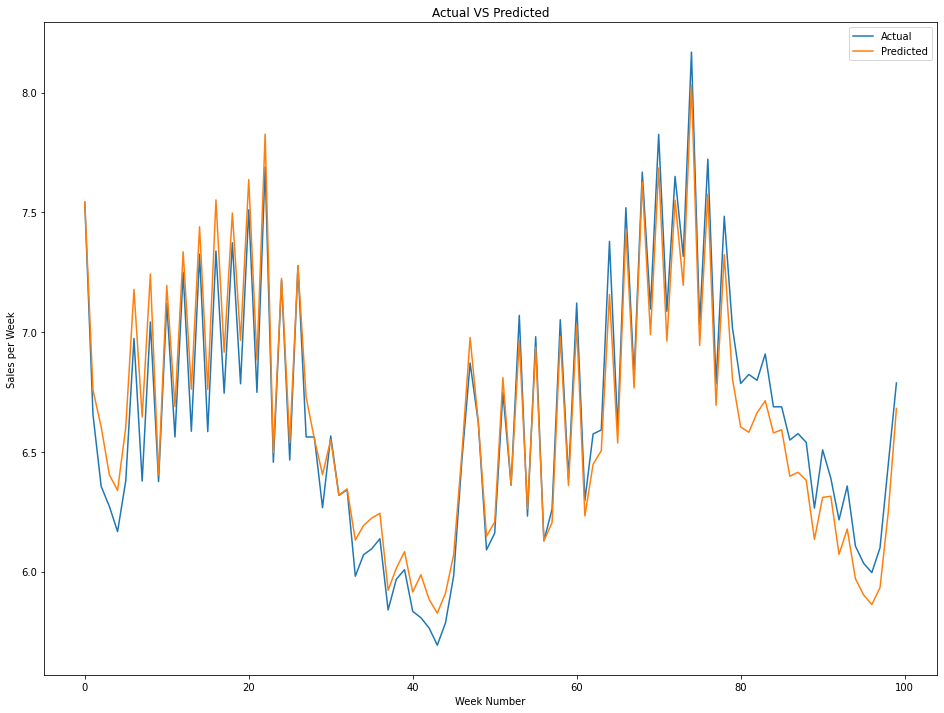

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
# Plot the actual y values
plt.plot(y_2, label='Actual')

# Plot the predicted y values
plt.plot(y_pred_2, label='Predicted')

# Add labels and legend
plt.xlabel('Week Number')
plt.ylabel('Sales per Week')
plt.legend()
plt.title('Actual VS Predicted')

# Show the plot
plt.show()

After Feature Selection

In [0]:
# # feature selection
features = ['price','seas_index',*week_sales_MSM_2.columns[19:25]] 
target = week_sales_MSM_2.columns[25]
X_2, y_2, X_train_2, y_train_2, X_test_2, y_test_2 = data_split(week_sales_MSM_2, features, target)
# Add a constant to the independent variables
X_2 = sm.add_constant(X_2)
# Create an OLS model and fit it to data
model_s_2 = sm.OLS(y_2, X_2).fit()
y_pred_2 = model_s_2.predict(X_2)
model_s_2.summary()

OLS Regression Results 
 
 Dep. Variable: Log_qty_week R-squared: 0.934 
 
 
 Model: OLS Adj. R-squared: 0.929 
 
 
 Method: Least Squares F-statistic: 161.7 
 
 
 Date: Thu, 20 Apr 2023 Prob (F-statistic): 2.33e-50 
 
 
 Time: 00:18:50 Log-Likelihood: 57.363 
 
 
 No. Observations: 100 AIC: -96.73 
 
 
 Df Residuals: 91 BIC: -73.28 
 
 
 Df Model: 8 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 const 6.1712 0.331 18.665 0.000 5.514 6.828 
 
 
 price -0.2394 0.065 -3.710 0.000 -0.367 -0.111 
 
 
 seas_index 1.1615 0.100 11.620 0.000 0.963 1.360 
 
 
 Display 0.3227 0.158 2.046 0.044 0.009 0.636 
 
 
 Flyer 0.4441 0.064 6.938 0.000 0.317 0.571 
 
 
 Facebook Banner Scaled_Imp -0.0807 0.031 -2.625 0.010 -0.142 -0.020 
 
 
 Google Paid Search Scaled_Imp 0.1430 0.032 4.497 0.000 0.080 0.206 
 
 
 Radio_reach 0.2320 0.051 4.557 0.000 0.131 0.333 
 
 
 TV_reach 0.3831 0.062 6.226 0.000 0.261 0.505 
 
 
 
 
 Omnibus: 15.381 Durbin-Watson: 0.308 
 
 
 Prob(Omnibus): 0.000 Jarque-Bera (JB): 4.388 
 
 
 Skew: 0.045 Prob(JB): 0.111 
 
 
 Kurtosis: 1.978 Cond. No. 120. 
 
 Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

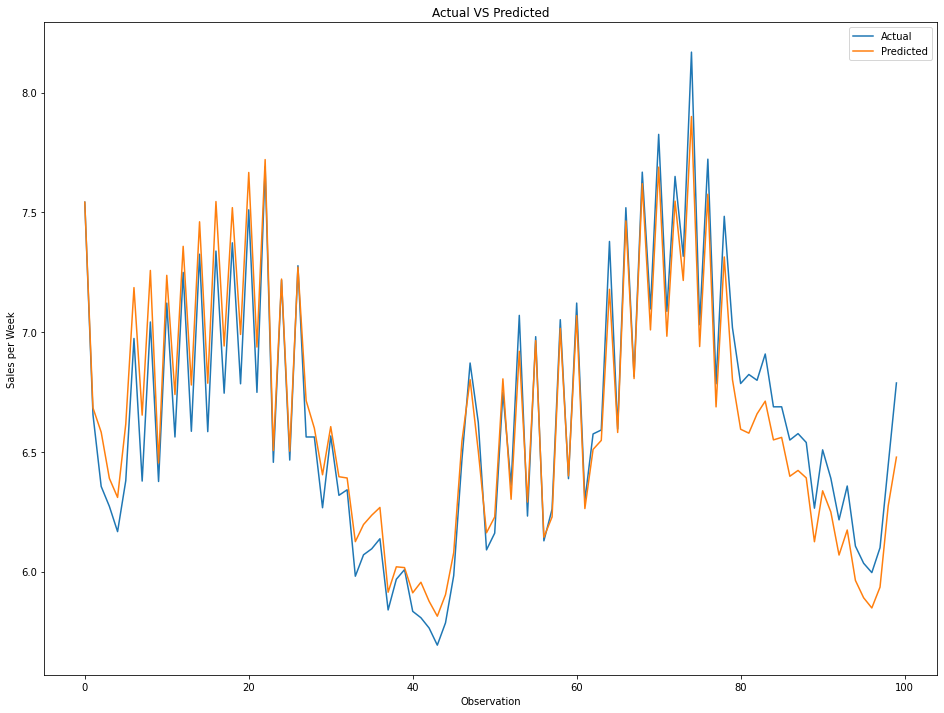

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
# Plot the actual y values
plt.plot(y_2, label='Actual')

# Plot the predicted y values
plt.plot(y_pred_2, label='Predicted')

# Add labels and legend
plt.xlabel('Observation')
plt.ylabel('Sales per Week')
plt.legend()
plt.title('Actual VS Predicted')

# Show the plot
plt.show()

Model of 23141593

In [0]:

features = ['price','seas_index', *week_sales_MSM_2.columns[9:25]] #*week_sales_MSM_2.columns[9:21],*week_sales_MSM_2.columns[29:35]
target = week_sales_MSM_2.columns[25]
X_3, y_3, X_train_3, y_train_3, X_test_3, y_test_3 = data_split(week_sales_MSM_3, features, target)
# Add a constant to the independent variables
X_3 = sm.add_constant(X_3)
# Create an OLS model and fit it to data
model_3 = sm.OLS(y_3, X_3).fit()
y_pred_3 = model_3.predict(X_3)
model_3.summary()

OLS Regression Results 
 
 Dep. Variable: Log_qty_week R-squared: 0.926 
 
 
 Model: OLS Adj. R-squared: 0.909 
 
 
 Method: Least Squares F-statistic: 56.19 
 
 
 Date: Wed, 19 Apr 2023 Prob (F-statistic): 3.92e-38 
 
 
 Time: 23:56:52 Log-Likelihood: -3.3808 
 
 
 No. Observations: 100 AIC: 44.76 
 
 
 Df Residuals: 81 BIC: 94.26 
 
 
 Df Model: 18 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 const 4.5979 0.545 8.436 0.000 3.513 5.682 
 
 
 price -0.0847 0.033 -2.563 0.012 -0.151 -0.019 
 
 
 seas_index 1.0056 0.235 4.271 0.000 0.537 1.474 
 
 
 Christmas 1.3607 0.213 6.388 0.000 0.937 1.785 
 
 
 Easter -0.0500 0.203 -0.247 0.806 -0.454 0.354 
 
 
 Halloween 0.5179 0.208 2.488 0.015 0.104 0.932 
 
 
 Labor Day 0.0332 0.286 0.116 0.908 -0.537 0.603 
 
 
 Memorial Day 0.0822 0.205 0.401 0.690 -0.326 0.491 
 
 
 National Day 0.2791 0.234 1.191 0.237 -0.187 0.745 
 
 
 New Year 0.5675 0.291 1.949 0.055 -0.012 1.147 
 
 
 Pre Easter 0.4186 0.208 2.015 0.047 0.005 0.832 
 
 
 Pre Super Bowl 0.7714 0.222 3.482 0.001 0.331 1.212 
 
 
 Super Bowl 0.4522 0.210 2.149 0.035 0.033 0.871 
 
 
 Display 0.3229 0.107 3.005 0.004 0.109 0.537 
 
 
 Flyer 0.3184 0.097 3.274 0.002 0.125 0.512 
 
 
 Facebook Banner Scaled_Imp -0.0820 0.063 -1.305 0.196 -0.207 0.043 
 
 
 Google Paid Search Scaled_Imp 0.7020 0.064 10.965 0.000 0.575 0.829 
 
 
 Radio_reach 0.4810 0.103 4.688 0.000 0.277 0.685 
 
 
 TV_reach 0.7585 0.133 5.718 0.000 0.495 1.023 
 
 
 
 
 Omnibus: 10.237 Durbin-Watson: 0.378 
 
 
 Prob(Omnibus): 0.006 Jarque-Bera (JB): 3.904 
 
 
 Skew: -0.154 Prob(JB): 0.142 
 
 
 Kurtosis: 2.083 Cond. No. 271. 
 
 Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

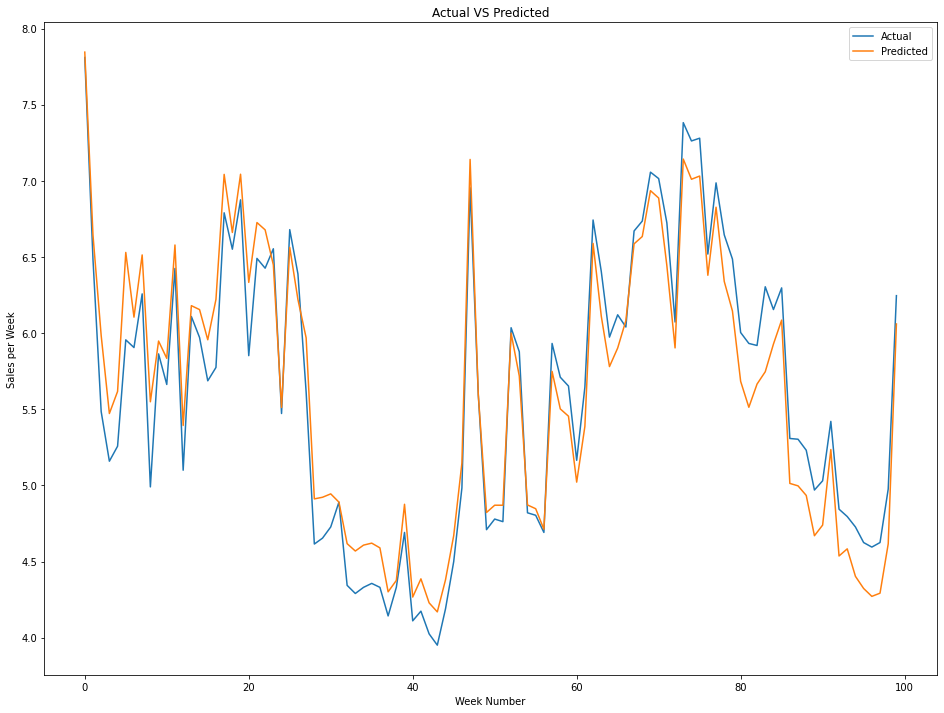

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
# Plot the actual y values
plt.plot(y_3, label='Actual')

# Plot the predicted y values
plt.plot(y_pred_3, label='Predicted')

# Add labels and legend
plt.xlabel('Week Number')
plt.ylabel('Sales per Week')
plt.legend()
plt.title('Actual VS Predicted')

# Show the plot
plt.show()

In [0]:
# # feature selection
features = ['price','seas_index','Christmas','Halloween', 'Pre Super Bowl','Super Bowl','Display','Flyer','Google Paid Search Scaled_Imp','Radio_reach','TV_reach'] 
target = week_sales_MSM_2.columns[25]
X_3, y_3, X_train_3, y_train_3, X_test_3, y_test_3 = data_split(week_sales_MSM_3, features, target)
# Add a constant to the independent variables
X_3 = sm.add_constant(X_3)
# Create an OLS model and fit it to data
model_s_3 = sm.OLS(y_3, X_3).fit()
y_pred_3 = model_s_3.predict(X_3)
model_s_3.summary()

OLS Regression Results 
 
 Dep. Variable: Log_qty_week R-squared: 0.916 
 
 
 Model: OLS Adj. R-squared: 0.905 
 
 
 Method: Least Squares F-statistic: 87.06 
 
 
 Date: Thu, 20 Apr 2023 Prob (F-statistic): 2.14e-42 
 
 
 Time: 00:41:36 Log-Likelihood: -9.7157 
 
 
 No. Observations: 100 AIC: 43.43 
 
 
 Df Residuals: 88 BIC: 74.69 
 
 
 Df Model: 11 
 
 
 Covariance Type: nonrobust 
 
 
 
 
 coef std err t P>|t| [0.025 0.975] 
 
 
 const 4.3788 0.499 8.777 0.000 3.387 5.370 
 
 
 price -0.0812 0.031 -2.579 0.012 -0.144 -0.019 
 
 
 seas_index 1.2025 0.208 5.788 0.000 0.790 1.615 
 
 
 Christmas 1.2929 0.216 5.997 0.000 0.864 1.721 
 
 
 Halloween 0.4502 0.208 2.166 0.033 0.037 0.863 
 
 
 Pre Super Bowl 0.7277 0.222 3.281 0.001 0.287 1.168 
 
 
 Super Bowl 0.4237 0.215 1.975 0.051 -0.003 0.850 
 
 
 Display 0.3353 0.105 3.182 0.002 0.126 0.545 
 
 
 Flyer 0.3003 0.097 3.107 0.003 0.108 0.492 
 
 
 Google Paid Search Scaled_Imp 0.6608 0.062 10.666 0.000 0.538 0.784 
 
 
 Radio_reach 0.4224 0.102 4.131 0.000 0.219 0.626 
 
 
 TV_reach 0.8043 0.128 6.300 0.000 0.551 1.058 
 
 
 
 
 Omnibus: 11.943 Durbin-Watson: 0.526 
 
 
 Prob(Omnibus): 0.003 Jarque-Bera (JB): 3.909 
 
 
 Skew: -0.053 Prob(JB): 0.142 
 
 
 Kurtosis: 2.037 Cond. No. 238. 
 
 Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

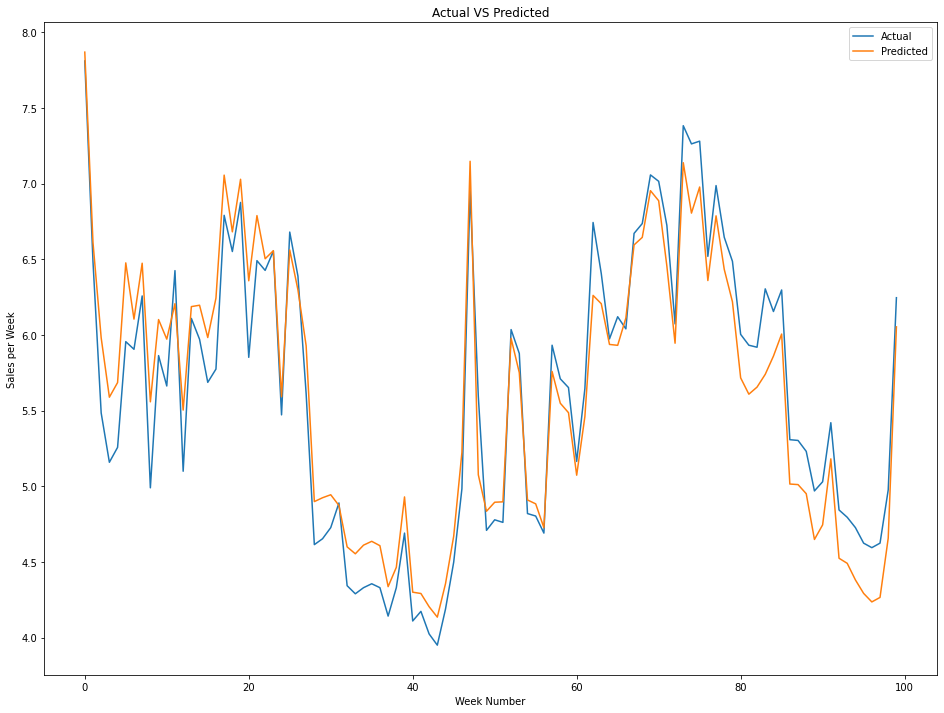

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
# Plot the actual y values
plt.plot(y_3, label='Actual')

# Plot the predicted y values
plt.plot(y_pred_3, label='Predicted')

# Add labels and legend
plt.xlabel('Week Number')
plt.ylabel('Sales per Week')
plt.legend()
plt.title('Actual VS Predicted')

# Show the plot
plt.show()

Decomposition - Incremental Sales

In [0]:

# price base: avg price
# i start from 13/3
def promo_decompose(df, y_pred, i):
    beta = coef_list[i]
    F1 = np.exp(beta * df.iloc[:,i])
    margin = np.exp(y_pred) - np.exp(y_pred)/F1
    return margin

In [0]:
# 23141592
# coefficient
coef_list = model_s_2.params.tolist()
feat_list = model_s_2.params.index
# decompose promotion
Decomposed_Sales_2 = pd.DataFrame()
for i in range(3,9):  
    Decomposed_Sales_2[feat_list[i]] = promo_decompose(X_2, y_pred_2, i)
# decompose price from mode to actual > discount
F1_price = np.exp(coef_list[1] * (X_2.iloc[:,1] - org_price_2))
margin_price = np.exp(y_pred_2) - np.exp(y_pred_2)/F1_price
Decomposed_Sales_2['discount'] = margin_price
Decomposed_Sales_2['contribution'] =  Decomposed_Sales_2['Display'] + Decomposed_Sales_2['Flyer'] + Decomposed_Sales_2['Facebook Banner Scaled_Imp'] + Decomposed_Sales_2['Google Paid Search Scaled_Imp'] + Decomposed_Sales_2['Radio_reach'] + Decomposed_Sales_2['TV_reach'] + Decomposed_Sales_2['discount']
Decomposed_Sales_2['base'] = np.exp(y_pred_2) - Decomposed_Sales_2['contribution']
Decomposed_Sales_2['total'] = np.exp(y_pred_2)
Decomposed_Sales_2['week_year'] = week_year
Decomposed_Sales_2

,Display,Flyer,Facebook Banner Scaled_Imp,Google Paid Search Scaled_Imp,Radio_reach,TV_reach,discount,contribution,base,total,week_year
0,520.215742,676.364671,-298.612403,329.201288,321.640585,511.120979,401.465586,2461.396449,-575.396449,1886.000000,4-2019
1,0.000000,0.000000,-37.895867,134.124550,137.020834,209.678360,0.000000,442.927877,356.420802,799.348679,5-2019
2,0.000000,0.000000,-35.466883,107.685445,116.208078,182.513391,0.000000,370.940030,351.469869,722.409899,6-2019
3,0.000000,0.000000,-91.013516,50.179153,88.096946,144.241268,0.000000,191.503851,404.211178,595.715030,7-2019
4,0.000000,0.000000,-76.276901,76.446615,73.291291,127.036522,0.000000,200.497528,349.644979,550.142507,8-2019
...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,9.987199,26.657418,0.000000,36.644617,325.294363,361.938980,47-2020
96,0.000000,0.000000,0.000000,0.000000,7.728587,23.128709,0.000000,30.857296,315.998863,346.856159,48-2020
97,0.000000,0.000000,0.000000,0.000000,6.784440,22.805119,17.686383,47.275941,331.093967,378.369908,49-2020
98,0.000000,0.000000,0.000000,0.000000,7.645667,28.904522,0.000000,36.550189,494.793897,531.344086,50-2020


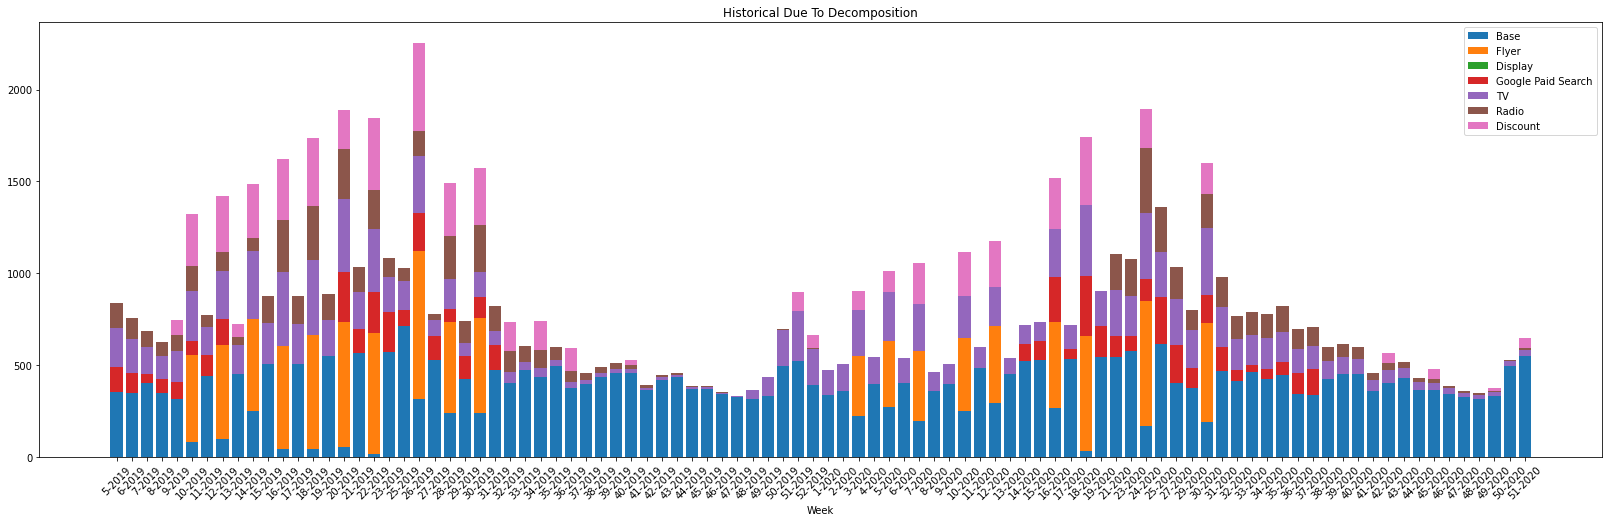

In [0]:
plt.figure(figsize=(28,8))
Temp_2 = Decomposed_Sales_2[Decomposed_Sales_2.base>=0]

plt.bar(Temp_2.week_year,Temp_2.base,label='Base')
plt.bar(Temp_2.week_year,Temp_2.Flyer,label='Flyer',bottom=Temp_2.base)
plt.bar(Temp_2.week_year,Temp_2.Display,label='Display',bottom=Temp_2.base+Temp_2.Flyer)
plt.bar(Temp_2.week_year,Temp_2['Google Paid Search Scaled_Imp'],label='Google Paid Search',bottom=Temp_2.base+Temp_2.Flyer+Temp_2.Display)
plt.bar(Temp_2.week_year,Temp_2.TV_reach,label='TV',bottom=Temp_2.base+Temp_2.Flyer+Temp_2.Display+Temp_2['Google Paid Search Scaled_Imp'])
plt.bar(Temp_2.week_year,Temp_2.Radio_reach,label='Radio',bottom=Temp_2.base+Temp_2.Flyer+Temp_2.Display+Temp_2['Google Paid Search Scaled_Imp']+Temp_2.TV_reach)
plt.bar(Temp_2.week_year,Temp_2.discount,label='Discount',bottom=Temp_2.base+Temp_2.Flyer+Temp_2.Display+Temp_2['Google Paid Search Scaled_Imp']+Temp_2.TV_reach+Temp_2.Radio_reach)

plt.legend()
plt.title("Historical Due To Decomposition")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.show()

In [0]:
def top_contributor(df,a,b):
    k=0
    Top_Contributor = pd.DataFrame(columns=['Year','Promo', 'Contribution'])
    for j in [2019,2020]:
        for i in df.columns[a:b]:
            ctri = round(df[df.year==j][i].sum()/df[df.year==j]['contribution'].sum()*100,2)
            Top_Contributor.loc[k] =[j,i,ctri]
            k = k + 1
    return Top_Contributor # contribution bar chart yearly

def plot_contribution(df, prod):
    df['Promo'] = np.where(df.Promo=='Google Paid Search Scaled_Imp', 'Google Paid Search',df.Promo)
    df['Promo'] = np.where(df.Promo=='Facebook Banner Scaled_Imp', 'Facebook Banner',df.Promo)
    df['Promo'] = np.where(df.Promo=='Radio_reach', 'Radio',df.Promo)
    df['Promo']= np.where(df.Promo=='TV_reach', 'TV',df.Promo)
    df_pivot = pd.pivot_table(df, values='Contribution', index='Promo', columns='Year')
    ax = df_pivot.plot(kind='bar', stacked=False, figsize=(16, 8))
    # set the chart title and axes labels
    ax.set_title('Contribution Percentage of Promotions on '+prod,fontsize=20)
    ax.set_xlabel('')
    # format y-axis tick labels as percentages
    plt.xticks(fontsize=15, rotation=0)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', labelleft=False)
    # add contribution percentage labels above each bar
     # add contribution percentage labels above each bar
    for bar in ax.patches:
    # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        text = f'{bar_value:,}%'
    # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
        text_y = bar.get_y() + bar_value
        bar_color = bar.get_facecolor()
        ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=10)

    # show the chart
    plt.show()


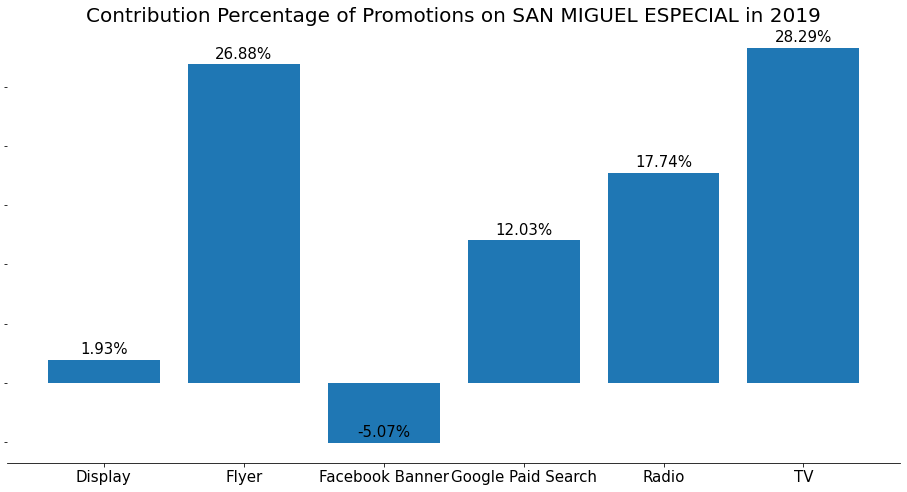

In [0]:
Decomposed_Sales_2 = pd.concat([week_sales_MSM_2[['week','year']].drop_duplicates(), Decomposed_Sales_2],axis=1) 
contri_2 = top_contributor(Decomposed_Sales_2,2,8)

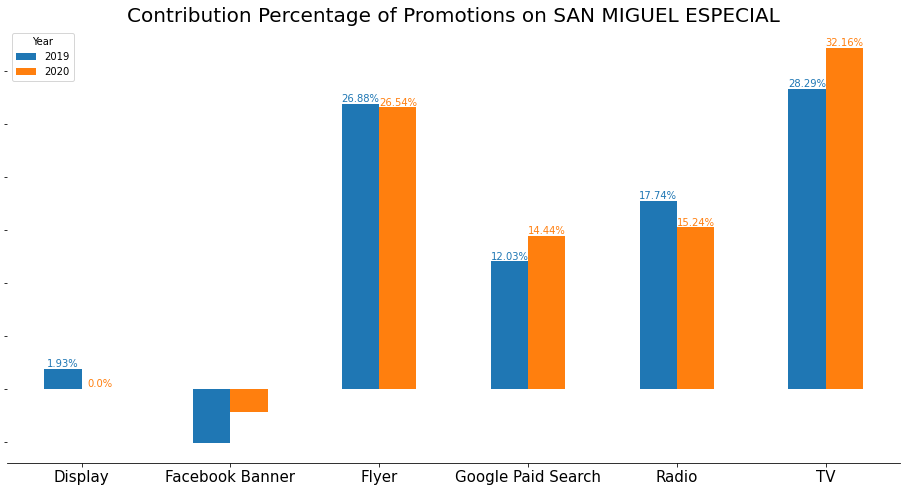

In [0]:
plot_contribution(contri_2, 'SAN MIGUEL ESPECIAL') # discount=18.21%

In [0]:
# decompose promotion 23141593
# coefficient
coef_list = model_s_3.params.tolist()
feat_list = model_s_3.params.index
Decomposed_Sales_3 = pd.DataFrame()
for i in range(7,12):  
    Decomposed_Sales_3[feat_list[i]] = promo_decompose(X_3, y_pred_3, i)
# decompose price from mode to actual > discount
F1_price_3 = np.exp(coef_list[1] * (X_3.iloc[:,1] - org_price_3))
margin_price_3 = np.exp(y_pred_3) - np.exp(y_pred_3)/F1_price_3
Decomposed_Sales_3['discount'] = margin_price_3
Decomposed_Sales_3['contribution'] = Decomposed_Sales_3['Display'] + Decomposed_Sales_3['Flyer'] + Decomposed_Sales_3['Google Paid Search Scaled_Imp']+ Decomposed_Sales_3['Radio_reach'] + Decomposed_Sales_3['TV_reach'] + Decomposed_Sales_3['discount']
Decomposed_Sales_3['base'] = np.exp(y_pred_2) - Decomposed_Sales_3['contribution'] 
Decomposed_Sales_3['total'] = np.exp(y_pred_2)
Decomposed_Sales_3

,Display,Flyer,Google Paid Search Scaled_Imp,Radio_reach,TV_reach,discount,contribution,base,total
0,744.106083,677.598115,1535.437286,753.856144,1266.993911,7.244655e+02,5702.457042,-3816.457042,1886.000000
1,0.000000,0.000000,425.284663,215.594440,350.986639,-1.136868e-13,991.865742,-192.517063,799.348679
2,0.000000,0.000000,208.064423,108.224260,181.066750,0.000000e+00,497.355433,225.054466,722.409899
3,0.000000,0.000000,89.332259,67.608553,118.008784,-5.684342e-14,274.949596,320.765434,595.715030
4,0.000000,0.000000,146.998329,67.524175,124.829073,0.000000e+00,339.351577,210.790930,550.142507
...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,3.635974,10.860198,0.000000e+00,14.496171,347.442809,361.938980
96,0.000000,0.000000,0.000000,2.781383,9.330773,0.000000e+00,12.112156,334.744003,346.856159
97,0.000000,0.000000,0.000000,2.309885,8.719840,0.000000e+00,11.029725,367.340183,378.369908
98,0.000000,0.000000,0.000000,2.746325,11.681736,0.000000e+00,14.428061,516.916025,531.344086


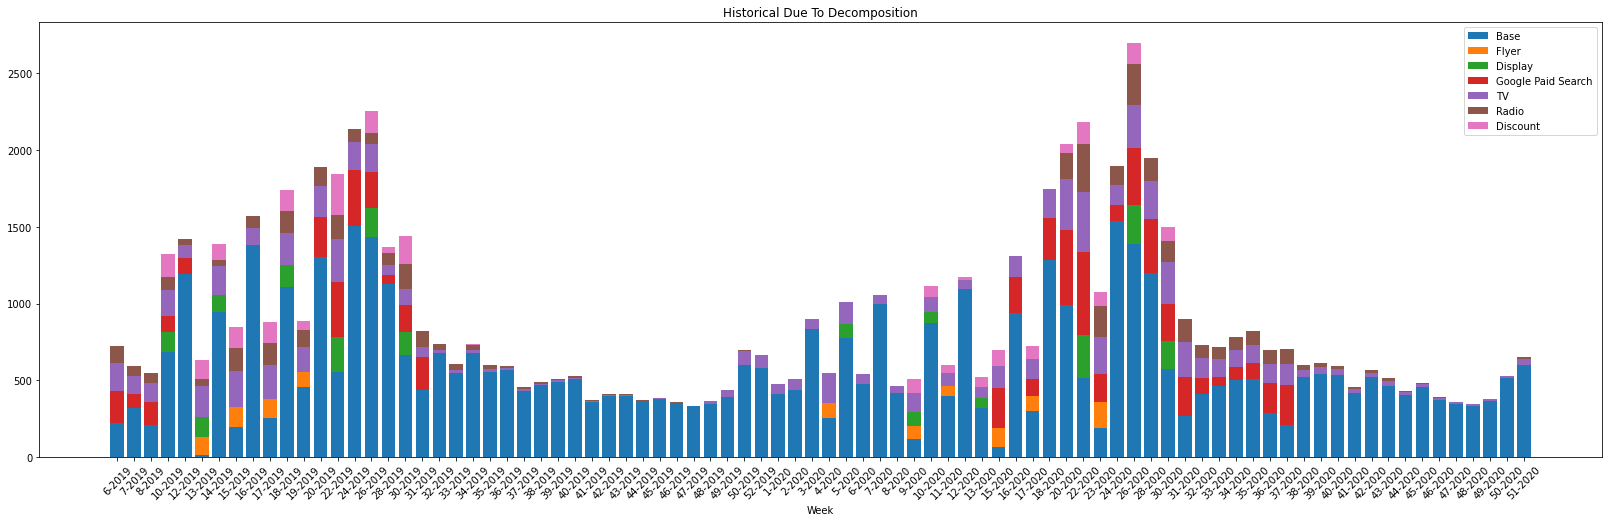

In [0]:
plt.figure(figsize=(28,8))
Decomposed_Sales_3['week_year'] = week_year
Temp_3 = Decomposed_Sales_3[Decomposed_Sales_3.base>=0]

plt.bar(Temp_3.week_year,Temp_3.base,label='Base')
plt.bar(Temp_3.week_year,Temp_3.Flyer,label='Flyer',bottom=Temp_3.base)
plt.bar(Temp_3.week_year,Temp_3.Display,label='Display',bottom=Temp_3.base+Temp_3.Flyer)
plt.bar(Temp_3.week_year,Temp_3['Google Paid Search Scaled_Imp'],label='Google Paid Search',bottom=Temp_3.base+Temp_3.Flyer+Temp_3.Display)
plt.bar(Temp_3.week_year,Temp_3.TV_reach,label='TV',bottom=Temp_3.base+Temp_3.Flyer+Temp_3.Display+Temp_3['Google Paid Search Scaled_Imp'])
plt.bar(Temp_3.week_year,Temp_3.Radio_reach,label='Radio',bottom=Temp_3.base+Temp_3.Flyer+Temp_3.Display+Temp_3['Google Paid Search Scaled_Imp']+Temp_3.TV_reach)
plt.bar(Temp_3.week_year,Temp_3.discount,label='Discount',bottom=Temp_3.base+Temp_3.Flyer+Temp_3.Display+Temp_3['Google Paid Search Scaled_Imp']+Temp_3.TV_reach+Temp_3.Radio_reach)

plt.legend()
plt.title("Historical Due To Decomposition")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.show()

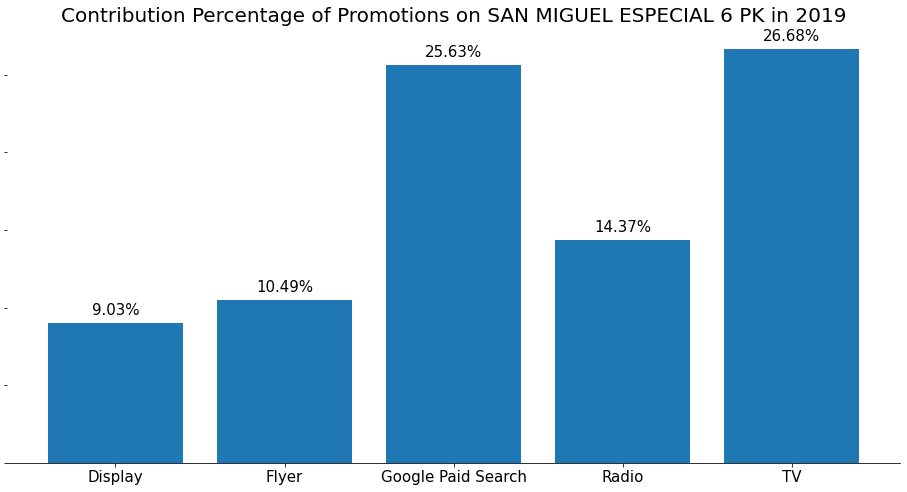

In [0]:
Decomposed_Sales_3 = pd.concat([week_sales_MSM_3[['week','year']].drop_duplicates(), Decomposed_Sales_3],axis=1) 
contri_3 = top_contributor(Decomposed_Sales_3,2,7)# discount=18.21%

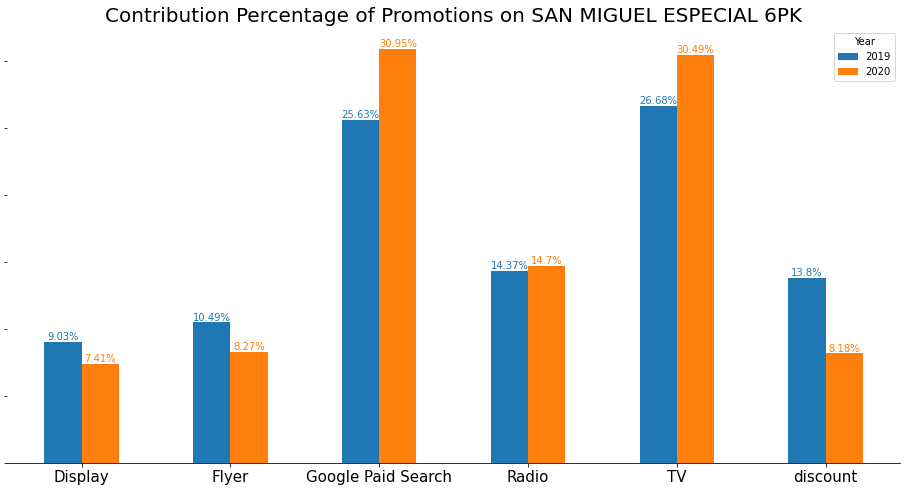

In [0]:
plot_contribution(contri_3, 'SAN MIGUEL ESPECIAL 6PK')

ROI

In [0]:
def Cost(sales_df, prod):
    cost = promo_MSM[promo_MSM[prod]==1][['year','week','vehicle','cost']]
    cost = pd.pivot_table(cost, values='cost', index=['year', 'week'], columns=['vehicle'], aggfunc=sum).reset_index()
    cost = pd.merge(sales_df[['week','year']].drop_duplicates(), cost, on=['year','week'],how='left')
    cost = cost.fillna(0)
    return cost
    
def ROI(Decomp_Sales, sales_df, X, cost):
    #Decomp_Sales = pd.merge(Decomp_Sales, sales_df[['week','year','price']],on=['year','week'])
    Decomp_Sales = Decomp_Sales.rename(columns={'Google Paid Search Scaled_Imp': 'Google Paid Search'})
    Decomp_Sales = Decomp_Sales.rename(columns={'Facebook Banner Scaled_Imp': 'Facebook Banner'})
    Decomp_Sales = Decomp_Sales.rename(columns={'Radio_reach': 'Radio'})
    Decomp_Sales = Decomp_Sales.rename(columns={'TV_reach': 'TV'})
    prod_cost = X.price.min()*0.8
    k=0
    roi_df = pd.DataFrame(columns=['Year','Promo', 'ROI'])
    for j in [2019,2020]:
        for i in ['Display', 'Flyer', 'Google Paid Search', 'Radio', 'TV']:
            roi = round((Decomp_Sales[Decomp_Sales.year==j][i]*(Decomp_Sales.price-prod_cost)).sum()/cost[cost.year==j][i].sum()*100,2)
            roi_df.loc[k] =[j,i,roi]
            k = k + 1
    return roi_df # contribution bar chart yearly

In [0]:
cost_2 = Cost(week_sales_MSM_2,'23141592')
ROI_2 = ROI(Decomposed_Sales_2,week_sales_MSM_2, X_2 ,cost_2)
ROI_2 = ROI_2.fillna(0)

In [0]:
ROI_2

,Year,Promo,ROI
0,2019,Display,9.23
1,2019,Flyer,37.75
2,2019,Google Paid Search,11.82
3,2019,Radio,28.99
4,2019,TV,13.18
5,2020,Display,0.00
6,2020,Flyer,40.32
7,2020,Google Paid Search,14.41
8,2020,Radio,23.85
9,2020,TV,35.91


In [0]:
def plot_ROI(df, prod):
    df_pivot = pd.pivot_table(df, values='ROI', index='Promo', columns='Year')
    ax = df_pivot.plot(kind='bar', stacked=False, figsize=(16, 8))
    # set the chart title and axes labels
    ax.set_title('ROI of Promotions on '+prod,fontsize=20)#+ ' in '+str(year)
    # format y-axis tick labels as percentages
    plt.xticks(fontsize=15, rotation=0)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', labelleft=False)
    ax.set_xlabel('')
    # add contribution percentage labels above each bar
    for bar in ax.patches:
    # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        text = f'{bar_value:,}%'
    # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
        text_y = bar.get_y() + bar_value
        bar_color = bar.get_facecolor()
        ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)
    plt.show()

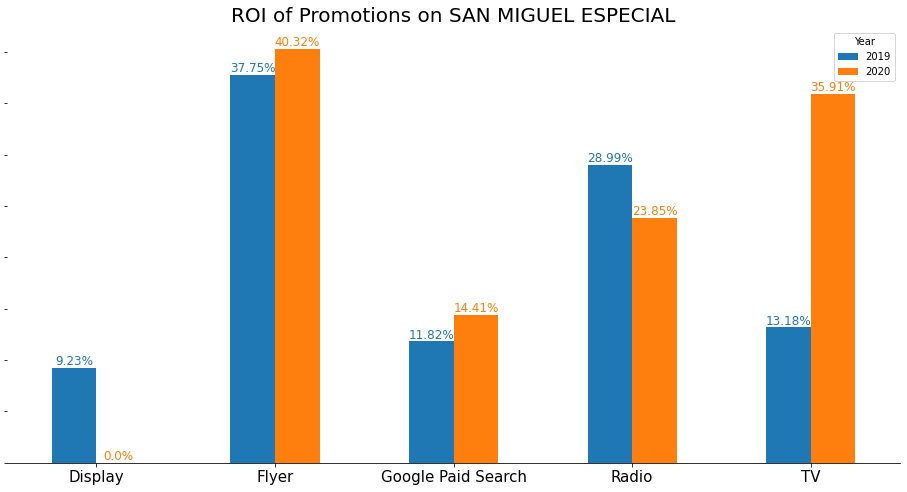

In [0]:
plot_ROI(ROI_2, 'SAN MIGUEL ESPECIAL')

In [0]:
cost_3 = Cost(week_sales_MSM_3,'23141593')
ROI_3 = ROI(Decomposed_Sales_3,week_sales_MSM_3, X_3 ,cost_3)
ROI_3

,Year,Promo,ROI
0,2019,Display,21.16
1,2019,Flyer,54.94
2,2019,Google Paid Search,81.59
3,2019,Radio,79.71
4,2019,TV,42.48
5,2020,Display,25.78
6,2020,Flyer,59.70
7,2020,Google Paid Search,103.77
8,2020,Radio,75.20
9,2020,TV,111.66


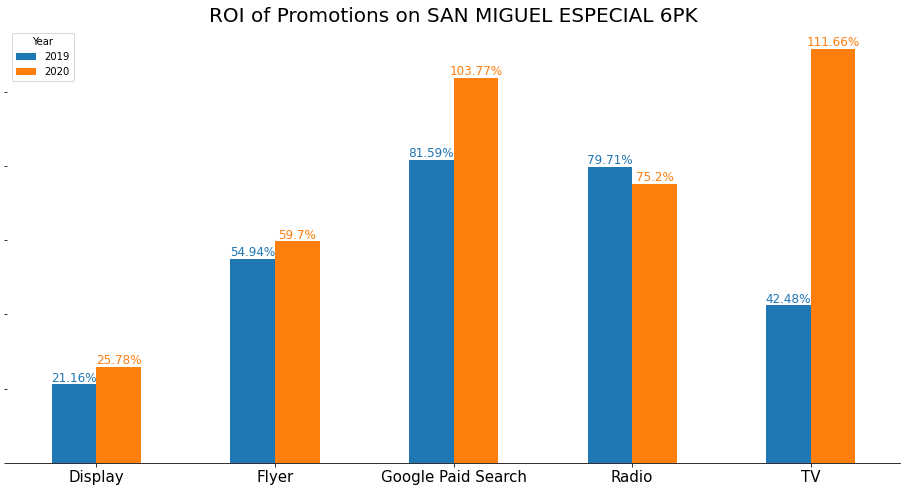

In [0]:
plot_ROI(ROI_3, 'SAN MIGUEL ESPECIAL 6PK')

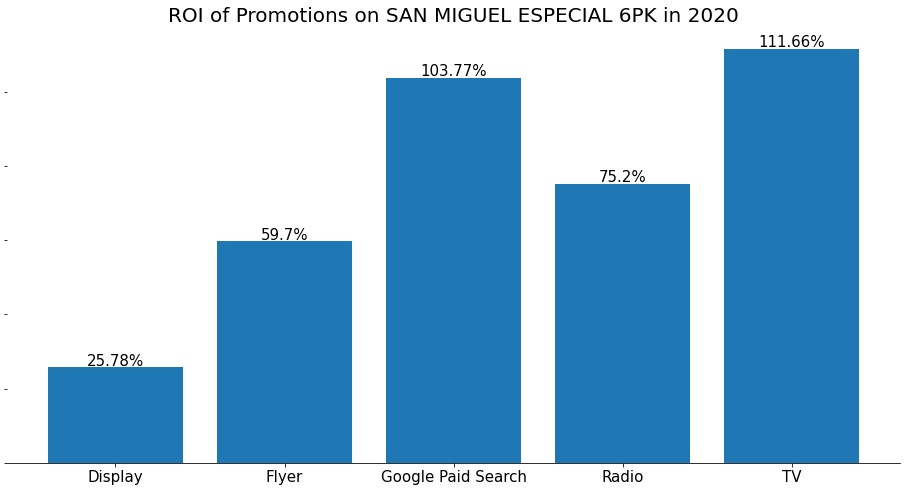

In [0]:
plot_ROI(ROI_3, 2020, 'SAN MIGUEL ESPECIAL 6PK')

In [0]:
# (Decomposed_Sales_2,week_sales_MSM_2, X_2 ,'23141592')
promo_cost_2 = promo_MSM[promo_MSM['23141592']==1][['year','week','vehicle','cost']]
promo_cost_2 = pd.pivot_table(promo_cost_2, values='cost', index=['year', 'week'], columns=['vehicle'], aggfunc=sum).reset_index()
promo_cost_2 = pd.merge(week_sales_MSM_2[['week','year']].drop_duplicates(),promo_cost_2,on=['year','week'],how='left')
promo_cost_2 = promo_cost_2.fillna(0)

Decomposed_Sales_2 = pd.concat([week_sales_MSM_2[['week','year']].drop_duplicates(), Decomposed_Sales_2],axis=1) 
Decomposed_Sales_2 = pd.merge(Decomposed_Sales_2,week_sales_MSM_2[['week','year','price']],on=['year','week'])

,week,year,Display,Facebook Banner,Flyer,Google Paid Search,Radio,TV
0,4,2019,4500.0,3642.25,2500.0,2428.0,2400.0,0.0
1,5,2019,0.0,1189.75,0.0,1880.0,1200.0,0.0
2,6,2019,0.0,1257.50,0.0,1674.0,0.0,0.0
3,7,2019,0.0,3782.50,0.0,889.0,0.0,0.0
4,8,2019,0.0,3143.75,0.0,1954.0,0.0,0.0
...,...,...,...,...,...,...,...,...
95,47,2020,0.0,0.00,0.0,0.0,0.0,0.0
96,48,2020,0.0,0.00,0.0,0.0,0.0,0.0
97,49,2020,0.0,0.00,0.0,0.0,0.0,0.0
98,50,2020,0.0,0.00,0.0,0.0,0.0,0.0


In [0]:
cost_2 = X_2.price.min()*0.8
print('Display ROI on SAN MIGUEL ESPECIAL:',str(round(((Decomposed_Sales_2.price-cost_2)*Decomposed_Sales_2.Display).sum()/promo_cost_2.Display.sum()*100,2))+'%')
print('Flyer ROI on SAN MIGUEL ESPECIAL:',str(round(((Decomposed_Sales_2.price-cost_2)*Decomposed_Sales_2.Flyer).sum()/promo_cost_2.Flyer.sum()*100,2))+'%')
print('Google Paid Search ROI on SAN MIGUEL ESPECIAL:',str(round(((Decomposed_Sales_2.price-cost_2)*Decomposed_Sales_2['Google Paid Search Scaled_Imp']).sum()/promo_cost_2['Google Paid Search'].sum()*100,2))+'%')
print('Radio ROI on SAN MIGUEL ESPECIAL:',str(round(((Decomposed_Sales_2.price-cost_2)*Decomposed_Sales_2.Radio_reach).sum()/promo_cost_2.Radio.sum()*100,2))+'%')
print('TV ROI on SAN MIGUEL ESPECIAL:',str(round(((Decomposed_Sales_2.price-cost_2)*Decomposed_Sales_2.TV_reach).sum()/promo_cost_2.TV.sum()*100,2))+'%')

Display ROI on SAN MIGUEL ESPECIAL: 9.23%
Flyer ROI on SAN MIGUEL ESPECIAL: 39.1%
Google Paid Search ROI on SAN MIGUEL ESPECIAL: 13.16%
Radio ROI on SAN MIGUEL ESPECIAL: 26.15%
TV ROI on SAN MIGUEL ESPECIAL: 20.57%


In [0]:
promo_cost_3 = promo_MSM[promo_MSM['23141593']==1][['year','week','vehicle','cost']]
promo_cost_3 = pd.pivot_table(promo_cost_3, values='cost', index=['year', 'week'], columns=['vehicle'], aggfunc=sum).reset_index()
promo_cost_3 = pd.merge(week_sales_MSM_3[['week','year']].drop_duplicates(),promo_cost_3,on=['year','week'],how='left')
promo_cost_3 = promo_cost_3.fillna(0)
Decomposed_Sales_3 = pd.concat([week_sales_MSM_3[['week','year']].drop_duplicates(), Decomposed_Sales_3],axis=1) 
Decomposed_Sales_3 = pd.merge(Decomposed_Sales_3,week_sales_MSM_3[['week','year','price']],on=['year','week'])

In [0]:
cost_3 = X_3.price.min()*0.8
print('Display ROI on SAN MIGUEL ESPECIAL 6 PK:',str(round(((Decomposed_Sales_3.price-cost_3)*Decomposed_Sales_3.Display).sum()/promo_cost_3.Display.sum()*100,2))+'%')
print('Flyer ROI on SAN MIGUEL ESPECIAL 6 PK:',str(round(((Decomposed_Sales_3.price-cost_3)*Decomposed_Sales_3.Flyer).sum()/promo_cost_3.Flyer.sum()*100,2))+'%')
print('Google Paid Search ROI on SAN MIGUEL ESPECIAL 6 PK:',str(round(((Decomposed_Sales_3.price-cost_3)*Decomposed_Sales_3['Google Paid Search Scaled_Imp']).sum()/promo_cost_3['Google Paid Search'].sum()*100,2))+'%')
print('Radio ROI on SAN MIGUEL ESPECIAL 6 PK:',str(round(((Decomposed_Sales_3.price-cost_3)*Decomposed_Sales_3.Radio_reach).sum()/promo_cost_3.Radio.sum()*100,2))+'%')
print('TV ROI on SAN MIGUEL ESPECIAL 6 PK:',str(round(((Decomposed_Sales_3.price-cost_3)*Decomposed_Sales_3.TV_reach).sum()/promo_cost_3.TV.sum()*100,2))+'%')

Display ROI on SAN MIGUEL ESPECIAL 6 PK: 23.31%
Flyer ROI on SAN MIGUEL ESPECIAL 6 PK: 57.15%
Google Paid Search ROI on SAN MIGUEL ESPECIAL 6 PK: 93.06%
Radio ROI on SAN MIGUEL ESPECIAL 6 PK: 77.21%
TV ROI on SAN MIGUEL ESPECIAL 6 PK: 64.96%


Predict Sales in 2023

SAN MIGUEL ESPECIAL

In [0]:
cost_2['prod_cost'] = X_2.price.min()*0.8
profit_2019 = week_sales_MSM_2[week_sales_MSM_2.year==2019].amt_week.sum() - cost_2[cost_2.year==2019].iloc[:,2:].sum().sum()
profit_2020 = (np.exp(y_pred_2)*week_sales_MSM_2[week_sales_MSM_2.year==2020].price).sum() - cost_2[cost_2.year==2020].iloc[:,2:].sum().sum()

In [0]:
import random
week_sales_MSM_2_2023 = week_sales_MSM_2[week_sales_MSM_2.year==2020].copy()
week_sales_MSM_2_2023['Facebook Banner Scaled_Imp'] = 0
# Number of 0s to convert
num_to_convert = 4
zero_indices = [i for i in range(49, 49+len(week_sales_MSM_2_2023['Flyer'])) if week_sales_MSM_2_2023['Flyer'][i] == 0]
indices_to_convert = random.sample(zero_indices, num_to_convert)
for i in indices_to_convert:
    week_sales_MSM_2_2023['Flyer'][i] = 1
#week_sales_MSM_2_2023['TV_reach'] = week_sales_MSM_2_2023['TV_reach']*1.1
#week_sales_MSM_2_2023['Google Paid Search Scaled_Imp'] = week_sales_MSM_2_2023['Google Paid Search Scaled_Imp']*2
# # feature selection
features = ['price','seas_index',*week_sales_MSM_2.columns[19:25]] 
target = week_sales_MSM_2.columns[25]
X_2_2023 = week_sales_MSM_2_2023[features]
Y_2_2023 = week_sales_MSM_2_2023[target]
# Add a constant to the independent variables
X_2_2023 = sm.add_constant(X_2_2023)
y_pred_2_2023 = model_s_2.predict(X_2_2023)
revenue_2023 = (np.exp(y_pred_2_2023)*X_2_2023.price).sum()
revenue_2023

Out[1172]: 224827.42453657684

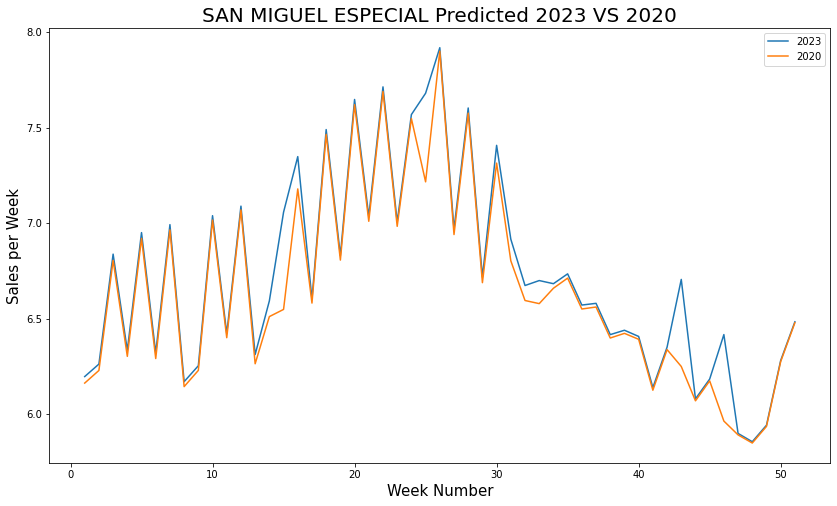

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
# Plot the actual y values
plt.plot(range(1,52), y_pred_2_2023, label='2023')

# Plot the predicted y values
plt.plot(range(1,52), y_pred_2[49:], label='2020')
# Add labels and legend
plt.xlabel('Week Number', fontsize=15)
plt.ylabel('Sales per Week', fontsize=15)
plt.legend()
plt.title('SAN MIGUEL ESPECIAL Predicted 2023 VS 2020', fontsize=20)

# Show the plot
plt.show()

In [0]:
cost_2_2023=cost_2[cost_2.year==2020].copy()
cost_2_2023['Facebook Banner'] = 0
cost_2_2023['Flyer'] = week_sales_MSM_2_2023['Flyer']*1750
#cost_2_2023['Google Paid Search'] = cost_2_2023['Google Paid Search']*1.1
#cost_2_2023['TV'] = cost_2_2023['TV']*1.1
cost_2_2023['year'] = 2023
profit_2023 = revenue_2023 - cost_2_2023.iloc[:,2:].sum().sum()
round((profit_2023 - profit_2020)/profit_2020*100,2)

Out[1174]: 19.5

SAN MIGUEL ESPECIAL 6PK

In [0]:
import random
cost_3['prod_cost'] = X_3.price.min()*0.8
profit_2019 = week_sales_MSM_3[week_sales_MSM_3.year==2019].amt_week.sum() - cost_3[cost_3.year==2019].iloc[:,2:].sum().sum()
profit_2020 = (np.exp(y_pred_3)*week_sales_MSM_3[week_sales_MSM_3.year==2020].price).sum() - cost_3[cost_3.year==2020].iloc[:,2:].sum().sum()
week_sales_MSM_3_2023 = week_sales_MSM_3[week_sales_MSM_3.year==2020].copy()
week_sales_MSM_3_2023['Facebook Banner Scaled_Imp'] = 0
# Number of 0s to convert
num_to_convert = 0
zero_indices = [i for i in range(49, 49+len(week_sales_MSM_3_2023['Flyer'])) if week_sales_MSM_3_2023['Flyer'][i] == 0]
indices_to_convert = random.sample(zero_indices, num_to_convert)
for i in indices_to_convert:
    week_sales_MSM_3_2023['Flyer'][i] = 1
week_sales_MSM_3_2023['TV_reach'] = week_sales_MSM_3_2023['TV_reach']*1.1
week_sales_MSM_3_2023['Google Paid Search Scaled_Imp'] = week_sales_MSM_3_2023['Google Paid Search Scaled_Imp']*1.1
# # feature selection
features = ['price','seas_index','Christmas','Halloween', 'Pre Super Bowl','Super Bowl','Display','Flyer','Google Paid Search Scaled_Imp','Radio_reach','TV_reach'] 
target = week_sales_MSM_2.columns[25]
X_3_2023 = week_sales_MSM_3_2023[features]
Y_3_2023 = week_sales_MSM_3_2023[target]
# Add a constant to the independent variables
X_3_2023 = sm.add_constant(X_3_2023)
y_pred_3_2023 = model_s_3.predict(X_3_2023)
revenue_2023 = (np.exp(y_pred_3_2023)*X_3_2023.price).sum()
revenue_2023

Out[1210]: 266737.64441859233

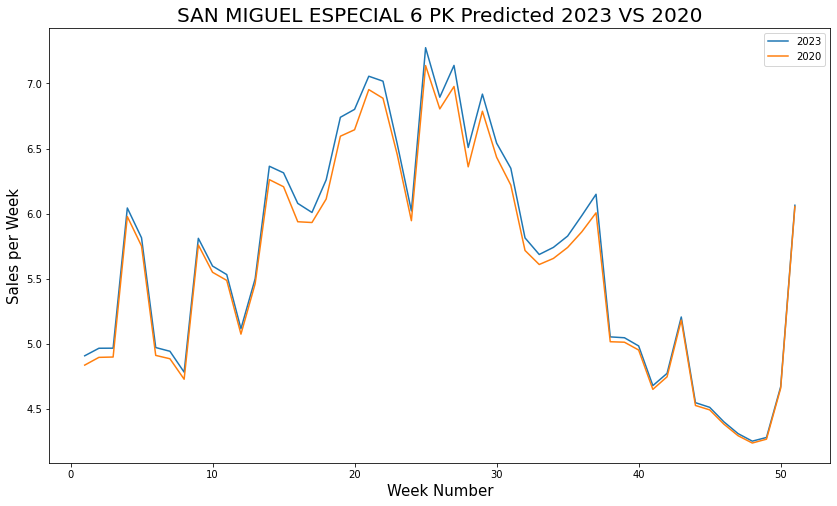

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
# Plot the actual y values
plt.plot(range(1,52), y_pred_3_2023, label='2023')

# Plot the predicted y values
plt.plot(range(1,52), y_pred_3[49:], label='2020')
# Add labels and legend
plt.xlabel('Week Number', fontsize=15)
plt.ylabel('Sales per Week', fontsize=15)
plt.legend()
plt.title('SAN MIGUEL ESPECIAL 6 PK Predicted 2023 VS 2020', fontsize=20)

# Show the plot
plt.show()

In [0]:
cost_3_2023=cost_3[cost_3.year==2020].copy()
cost_3_2023['Facebook Banner'] = 0
cost_3_2023['Flyer'] = week_sales_MSM_3_2023['Flyer']*1750
cost_3_2023['Google Paid Search'] = cost_3_2023['Google Paid Search']*1.1
cost_3_2023['TV'] = cost_3_2023['TV']*1.1
cost_3_2023['year'] = 2023
profit_2023 = revenue_2023 - cost_3_2023.iloc[:,2:].sum().sum()
round((profit_2023 - profit_2020)/profit_2020*100,2)

Out[1211]: 35.52